In [24]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate data

In [25]:
import generate_data

X, Y = generate_data.generate_2d_data()

In [31]:
X.shape

(500, 2)

In [32]:
Y.shape

(500,)

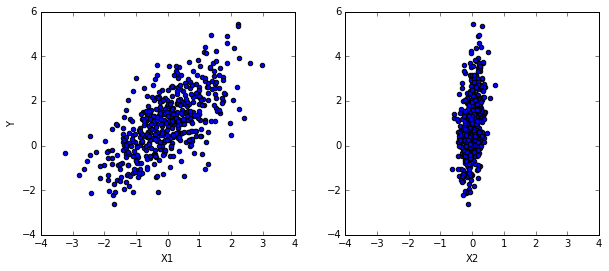

In [33]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X[:,0], Y)
axes[1].scatter(X[:,1], Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

## Learn using a line

In [34]:
import pymc3
from pymc3.distributions import  Normal, HalfNormal
from pymc3 import Model

In [157]:
basic_model = Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

Applied log-transform to sigma and added transformed sigma_log_ to model.


In [158]:
import pprint

In [159]:
from scipy import optimize

# Point estimate of the parameters
MAP = pymc3.find_MAP(model=basic_model, fmin=optimize.fmin_powell)

pprint.pprint(MAP)

{'alpha': array(1.057007553910048),
 'beta': array([ 0.90912262,  2.61397792]),
 'sigma_log_': array(-0.09382419494383673)}


In [160]:
MAP["beta"][1]

2.6139779228083664

In [161]:
def model_prediction(X, alpha, beta):
    return  alpha + beta[0]*X[:,0] + beta[1]*X[:,1]

In [162]:
## plot model
x1_grid = np.linspace(-4, 4, 200)
x2_grid = np.linspace(-4, 4, 200)

X_grid = np.vstack((x1_grid, x2_grid)).T

In [163]:
predictions = model_prediction(X_grid, MAP["alpha"],MAP["beta"])

In [164]:
predictions.shape

(200,)

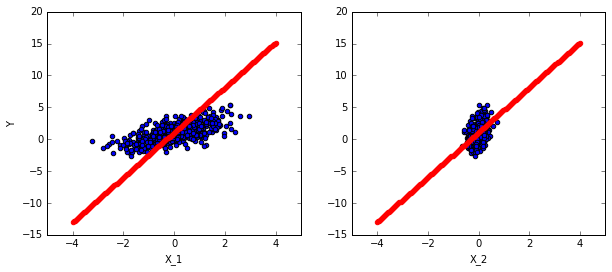

In [165]:
%matplotlib inline

## plot data
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X[:,0], Y)
axes[1].scatter(X[:,1], Y)

# Write 
axes[0].set_ylabel('Y');
axes[0].set_xlabel('X_1');
axes[1].set_xlabel('X_2');

axes[0].scatter(x1_grid,
                predictions ,
                color="r")

axes[1].scatter(x2_grid,
                predictions,
                color="r")

### You said bayesian inference!

In [87]:
basic_model = Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

Applied log-transform to sigma and added transformed sigma_log_ to model.


In [88]:
with Model() as model:
      
    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)
    
    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Define likelihood
    likelihood = pymc3.Normal('y', 
                              mu= mu,
                              sd=sigma, 
                              observed=Y)
       
    # Inference!
    start = pymc3.find_MAP() # Find starting value by optimization
    step = pymc3.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pymc3.sample(2000, step, start=start, progressbar=True) # draw 2000 posterior samples using NUTS sampling

Applied log-transform to sigma and added transformed sigma_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 2.9 sec

In [89]:
start

{'alpha': array(1.0570074663401772),
 'beta': array([ 0.90912083,  2.61397635]),
 'sigma_log_': array(-0.09382885897159576)}

In [95]:
print(trace["alpha"].shape)
print(trace["beta"].shape)
print(trace["sigma_log_"].shape)

(2000,)
(2000, 2)
(2000,)


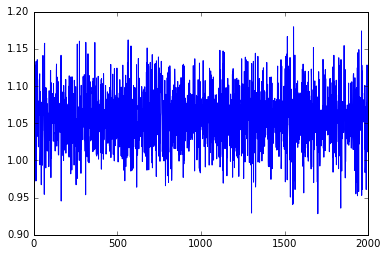

In [97]:
plt.plot(trace["alpha"])

In [100]:
help(pm.glm)

Help on package pymc3.glm in pymc3:

NAME
    pymc3.glm

FILE
    /home/david/anaconda/lib/python2.7/site-packages/pymc3/glm/__init__.py

PACKAGE CONTENTS
    families
    glm




## Learning using a MLP

In [92]:
import theano
import theano.tensor as T
import pymc3
import pymc3 as pm

X_train = np.vstack((X1,X2)).T
Y_train = Y

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

In [93]:
std_val = 0.01
n_hidden = 3
input_dim = 2
output_dim = 1

In [94]:
# Initialize random weights between each layer
init_w1 = np.random.randn(input_dim , n_hidden)
init_b1 = np.random.randn(n_hidden)

init_w2 = np.random.randn(n_hidden, output_dim)
init_b2 = np.random.randn(output_dim )

In [11]:
mlp = pymc3.Model()

with mlp:
    #######################################
    # Prior distributions over parameters #
    #######################################
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=std_val, 
                             shape=(input_dim , n_hidden), 
                             testval=init_w1)
    
    bias_in_1 =  pm.Normal('b_in_1', 0, sd=1, 
                           shape= (n_hidden,), 
                           testval=init_b1)
            
    # Weights from 1st to 2nd (output) layer
    weights_1_out = pm.Normal('w_1_2', 0, sd=std_val, 
                              shape=(n_hidden,1 ), 
                              testval=init_w2)
    
    bias_in_2 =  pm.Normal('b_in_2', 0, sd=1, 
                           shape= (output_dim,), 
                           testval=init_b2)
    
    sigma = pymc3.HalfCauchy('sigma', beta=10, testval=1.)
    
    ####################
    # Model definition #
    ####################
    
    # Expected value of outcome
    act_1 = T.nnet.relu(T.dot(ann_input, weights_in_1) + bias_in_1)
    act_out = T.dot(act_1, weights_1_out) + bias_in_2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=act_out, observed=ann_output )
    #Y_obs = Normal('Y_obs', mu=act_out, sd=sigma, observed=ann_output)

Applied log-transform to sigma and added transformed sigma_log_ to model.


In [12]:
with mlp:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    mu, sds, elbo = pymc3.variational.advi(n=1000)
    step = pm.NUTS(scaling=mlp.dict_to_array(sds))
    #trace = pymc3.sample(2000, step, start=mu, progressbar=True)
    trace = pm.sample(40, step, start=mu, progressbar=True)

Iteration 0 [0%]: ELBO = -733871.15
Iteration 10 [10%]: Average ELBO = -1954153.0
Iteration 20 [20%]: Average ELBO = -1919531.23
Iteration 30 [30%]: Average ELBO = -1043265.83
Iteration 40 [40%]: Average ELBO = -1163135.72
Iteration 50 [50%]: Average ELBO = -1699824.8
Iteration 60 [60%]: Average ELBO = -1403209.21
Iteration 70 [70%]: Average ELBO = -1757918.51
Iteration 80 [80%]: Average ELBO = -1500099.12
Iteration 90 [90%]: Average ELBO = -2478005.0
Finished [100%]: Average ELBO = -1559501.1
 [-----------------100%-----------------] 100 of 100 complete in 1827.3 sec

In [29]:
trace

<MultiTrace: 1 chains, 100 iterations, 6 variables>

In [24]:
mu

{'b_in_1': array([-1.46601897,  0.34725075, -0.71221249]),
 'b_in_2': array([ 0.32963239]),
 'sigma_log_': array(0.032373935837944685),
 'w_1_2': array([[-1.08540152],
        [-0.34206395],
        [-1.16756966]]),
 'w_in_1': array([[ 1.54023837,  1.62239749, -0.51533674],
        [-0.23827144, -1.63940676, -0.69794288]])}

In [30]:
sds

{'b_in_1': array([ 0.99057302,  0.99472189,  0.99290521]),
 'b_in_2': array([ 0.99232117]),
 'sigma_log_': 1.0222703917349956,
 'w_1_2': array([[ 0.98812166],
        [ 0.98323173],
        [ 0.99179796]]),
 'w_in_1': array([[ 0.99097691,  0.99613005,  0.98677588],
        [ 0.98162774,  0.98547501,  0.9848238 ]])}

#### Looking at the trace 

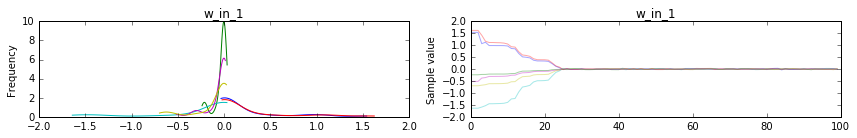

In [21]:
pm.traceplot(trace, ["w_in_1"]);

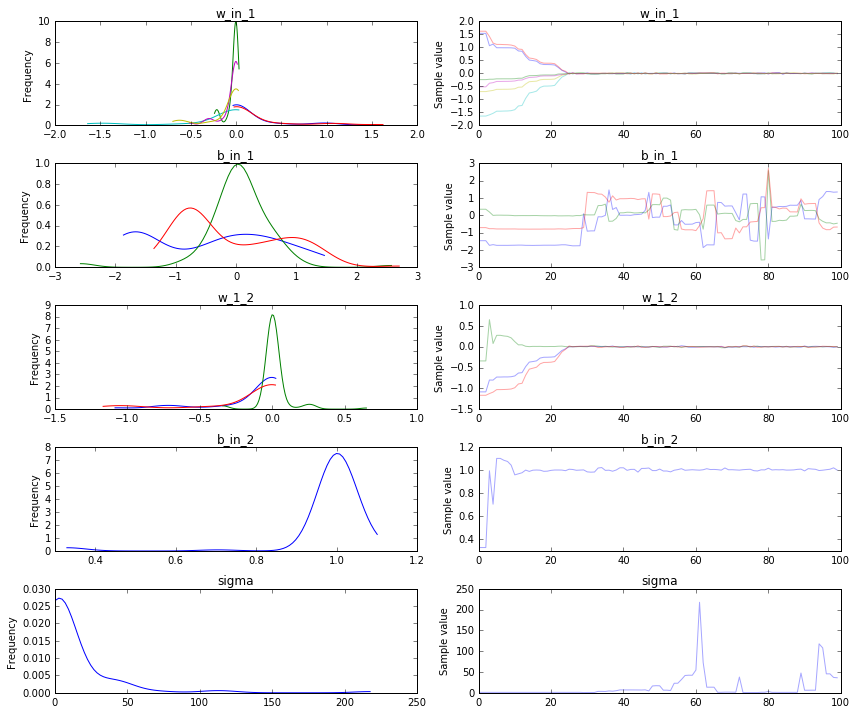

In [31]:
pm.traceplot(trace);

## Modelling without mp.sample

In [7]:
import theano
import theano.tensor as T
import pymc3
import pymc3 as pm
import numpy as np

X_train = np.vstack((X1,X2)).T
Y_train = Y

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

NameError: name 'X1' is not defined

In [8]:
std_val = 0.01
n_hidden = 3
input_dim = 2
output_dim = 1

In [ ]:
# Initialize random weights between each layer
init_w1 = np.random.randn(input_dim , n_hidden)
init_b1 = np.random.randn(n_hidden)

init_w2 = np.random.randn(n_hidden, output_dim)
init_b2 = np.random.randn(output_dim )

In [6]:
mlp = pymc3.Model()

with mlp:
    #######################################
    # Prior distributions over parameters #
    #######################################
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=std_val, 
                             shape=(input_dim , n_hidden), 
                             testval=init_w1)
    
    bias_in_1 =  pm.Normal('b_in_1', 0, sd=1, 
                           shape= (n_hidden,), 
                           testval=init_b1)
            
    # Weights from 1st to 2nd (output) layer
    weights_1_out = pm.Normal('w_1_2', 0, sd=std_val, 
                              shape=(n_hidden,1 ), 
                              testval=init_w2)
    
    bias_in_2 =  pm.Normal('b_in_2', 0, sd=1, 
                           shape= (output_dim,), 
                           testval=init_b2)
    
    sigma = pymc3.HalfCauchy('sigma', beta=10, testval=1.)
    
    ####################
    # Model definition #
    ####################
    
    # Expected value of outcome
    act_1 = T.nnet.relu(T.dot(ann_input, weights_in_1) + bias_in_1)
    act_out = T.dot(act_1, weights_1_out) + bias_in_2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=act_out, observed=ann_output )
    #Y_obs = Normal('Y_obs', mu=act_out, sd=sigma, observed=ann_output)

NameError: name 'std_val' is not defined

In [ ]:
with mlp:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=10000)

In [ ]:
plt.plot(v_params.elbo_vals)

In [5]:
v_params.elbo_vals.max()

NameError: name 'v_params' is not defined

In [51]:
v_params.__dict__

OrderedDict([('means',
              {'b_in_1': array([ 0.49522275, -0.53226334,  0.03748911]),
               'b_in_2': array([ 0.76447414]),
               'sigma_log_': array(1.8181888688277115),
               'w_1_2': array([[ 0.2700339 ],
                      [ 0.20067842],
                      [ 0.01704001]]),
               'w_in_1': array([[-0.10032066,  0.11094737, -0.1204965 ],
                      [ 0.00993304, -0.00445301,  0.00439356]])}),
             ('stds',
              {'b_in_1': array([ 0.47787591,  0.69267514,  0.53210746]),
               'b_in_2': array([ 0.25672104]),
               'sigma_log_': 1.5990871074378767,
               'w_1_2': array([[ 0.25658284],
                      [ 0.30396376],
                      [ 0.28030114]]),
               'w_in_1': array([[ 0.30312512,  0.36183955,  0.32422213],
                      [ 0.14278857,  0.15040091,  0.14145537]])}),
             ('elbo_vals',
              array([ -3514264.9788903 ,  -2676778.15976821

In [52]:
v_params[0]

{'b_in_1': array([ 0.49522275, -0.53226334,  0.03748911]),
 'b_in_2': array([ 0.76447414]),
 'sigma_log_': array(1.8181888688277115),
 'w_1_2': array([[ 0.2700339 ],
        [ 0.20067842],
        [ 0.01704001]]),
 'w_in_1': array([[-0.10032066,  0.11094737, -0.1204965 ],
        [ 0.00993304, -0.00445301,  0.00439356]])}

In [54]:
help(pm.variational)

Help on package pymc3.variational in pymc3:

NAME
    pymc3.variational

FILE
    /home/david/anaconda/lib/python2.7/site-packages/pymc3/variational/__init__.py

PACKAGE CONTENTS
    advi
    advi_minibatch




About the evidence lower bounds

- https://benmoran.wordpress.com/2015/02/21/variational-bayes-and-the-evidence-lower-bound/

### Can't we sample? Sure but it's slow...

In [224]:
with mlp:
    start = pymc3.find_MAP() # Find starting value by optimization
    step = pymc3.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pymc3.sample(100, step, start=start, progressbar=True) # draw 2000 posterior samples using NUTS sampling

 [-----------------100%-----------------] 100 of 100 complete in 125.3 sec

## Fix parameters of the model and make predictions